In [2]:
!pip install pandas sklearn xgboost hyperopt joblib

In [3]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.pipeline import Pipeline
import pickle
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import warnings
import joblib
from sklearn.feature_selection import SelectKBest, chi2
warnings.filterwarnings('ignore')


## Generate baseline model

In [4]:
df = pd.read_csv(r"/home/jovyan/work/data/input/merged_data/train/merged_train.csv",sep=';')
df.drop(["customerid"],axis=1,inplace=True)
X, y = df.drop(["good_bad_flag"],axis=1), df['good_bad_flag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)

baseline_model = xgb.XGBClassifier()
baseline_model.fit(X_train, y_train)

y_pred = baseline_model.predict(X_test)
baseline_accuracy = accuracy_score(y_test, y_pred)
print("BASELINE ACCURACY: ", baseline_accuracy)

BASELINE ACCURACY:  0.7484756097560976


In [5]:
# We select a k_fold number of splits for grid search 
k_folds = 5

## Generate model with base variables + Grid Search

In [ ]:
df = pd.read_csv(rf"/home/jovyan/work/data/input/merged_data/train/merged_train.csv",sep=';')
df.drop(["customerid"],axis=1,inplace=True)
X, y = df.drop(["good_bad_flag"],axis=1), df['good_bad_flag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

pipe = Pipeline([('fs', SelectKBest()),('clf', xgb.XGBClassifier(objective='binary:logistic'))])

# Define our search space for grid search
search_space = [
  {
    'clf__n_estimators': [100, 200, 300, 400],
    'clf__learning_rate': [0.001,0.01, 0.1],
    'clf__max_depth': range(5, 10),
    'clf__colsample_bytree': [i/10.0 for i in range(1, 3)],
    'clf__gamma': [i/10.0 for i in range(3)],
    'fs__score_func': [chi2],
  }
]
# Define cross validation
kfold = KFold(n_splits=k_folds)
# AUC and accuracy as score
scoring = {'AUC':'roc_auc', 'Accuracy':make_scorer(accuracy_score)}
# Define grid search
grid = GridSearchCV(
  pipe,
  param_grid=search_space,
  cv=kfold,
  scoring=scoring,
  refit='AUC',
  verbose=1,
  n_jobs=-1
)
# Fit grid search
complete_model = grid.fit(X_train, y_train)
predict_complete = complete_model.predict(X_test)
complete_accuracy = accuracy_score(y_test, predict_complete)
print('Best AUC Score: {}'.format(complete_model.best_score_))
print('Accuracy: {}'.format(complete_accuracy))

## Generate model with cluster feature + Grid Search

In [ ]:
df = pd.read_csv(rf"/home/jovyan/work/data/input/merged_data/train/cluster_train.csv",sep=';')
df.drop(["customerid"],axis=1,inplace=True)
X, y = df.drop(["good_bad_flag"],axis=1), df['good_bad_flag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

pipe = Pipeline([('fs', SelectKBest()),('clf', xgb.XGBClassifier(objective='binary:logistic'))])

# Define our search space for grid search
search_space = [
  {
    'clf__n_estimators': [100, 200, 300, 400],
    'clf__learning_rate': [0.001,0.01, 0.1],
    'clf__max_depth': range(5, 10),
    'clf__colsample_bytree': [i/10.0 for i in range(1, 3)],
    'clf__gamma': [i/10.0 for i in range(3)],
    'fs__score_func': [chi2],
  }
]
# Define cross validation
kfold = KFold(n_splits=k_folds)
# AUC and accuracy as score
scoring = {'AUC':'roc_auc', 'Accuracy':make_scorer(accuracy_score)}
# Define grid search
grid = GridSearchCV(
  pipe,
  param_grid=search_space,
  cv=kfold,
  scoring=scoring,
  refit='AUC',
  verbose=1,
  n_jobs=-1
)
# Fit grid search
cluster_model = grid.fit(X_train, y_train)
predict_cluster = cluster_model.predict(X_test)
cluster_accuracy = accuracy_score(y_test, predict_cluster)
print('Best AUC Score: {}'.format(cluster_model.best_score_))
print('Accuracy: {}'.format(cluster_accuracy))

## Generate model with top 10 features + Grid Search

In [9]:
df = pd.read_csv(rf"/home/jovyan/work/data/input/merged_data/train/top_10_train.csv",sep=';')
X, y = df.drop(["good_bad_flag"],axis=1), df['good_bad_flag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

pipe = Pipeline([('fs', SelectKBest()),('clf', xgb.XGBClassifier(objective='binary:logistic'))])

# Define our search space for grid search
search_space = [
  {
    'clf__n_estimators': [100, 200, 300, 400],
    'clf__learning_rate': [0.001,0.01, 0.1],
    'clf__max_depth': range(5, 10),
    'clf__colsample_bytree': [i/10.0 for i in range(1, 3)],
    'clf__gamma': [i/10.0 for i in range(3)],
    'fs__score_func': [chi2],
  }
]
# Define cross validation
kfold = KFold(n_splits=k_folds)
# AUC and accuracy as score
scoring = {'AUC':'roc_auc', 'Accuracy':make_scorer(accuracy_score)}
# Define grid search
grid = GridSearchCV(
  pipe,
  param_grid=search_space,
  cv=kfold,
  scoring=scoring,
  refit='AUC',
  verbose=1,
  n_jobs=-1
)
# Fit grid search
top_10_model = grid.fit(X_train, y_train)
predict_top_10 = top_10_model.predict(X_test)
top_10_accuracy = accuracy_score(y_test, predict_top_10)
print('Best AUC Score: {}'.format(top_10_model.best_score_))
print('Accuracy: {}'.format(top_10_accuracy))

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Best AUC Score: 0.6644940569743637
Accuracy: 0.7804878048780488


## Generate model with PCA + Grid Search

In [ ]:
df = pd.read_csv(rf"/home/jovyan/work/data/input/merged_data/train/pca_train.csv",sep=';')
X, y = df.drop(["good_bad_flag"],axis=1), df['good_bad_flag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

pipe = Pipeline([('fs', SelectKBest()),('clf', xgb.XGBClassifier(objective='binary:logistic'))])

# Define our search space for grid search
search_space = [
  {
    'clf__n_estimators': [100, 200, 300, 400],
    'clf__learning_rate': [0.001,0.01, 0.1],
    'clf__max_depth': range(5, 10),
    'clf__colsample_bytree': [i/10.0 for i in range(1, 3)],
    'clf__gamma': [i/10.0 for i in range(3)],
    'fs__score_func': [chi2],
  }
]
# Define cross validation
kfold = KFold(n_splits=k_folds)
# AUC and accuracy as score
scoring = {'AUC':'roc_auc', 'Accuracy':make_scorer(accuracy_score)}
# Define grid search
grid = GridSearchCV(
  pipe,
  param_grid=search_space,
  cv=kfold,
  scoring=scoring,
  refit='AUC',
  verbose=1,
  n_jobs=-1
)
# Fit grid search
pca_model = grid.fit(X_train, y_train)
predict_pca = pca_model.predict(X_test)
pca_accuracy = accuracy_score(y_test, predict_pca)
print('Best AUC Score: {}'.format(pca_model.best_score_))
print('Accuracy: {}'.format(pca_accuracy))

# Model comparison

In [ ]:
accuracies = [(baseline_accuracy, baseline_model, "baseline"), 
              (complete_accuracy, complete_model, "complete"),
              (top_10_accuracy, top_10_model, "top_10"),
              (cluster_accuracy, cluster_model, "cluster")]

best_model, max_acc, name = None, 0, None
for t in accuracies:
    if t[0] > max_acc:
        max_acc = t[0]
        best_model = t[1]
        name = t[2]

print("Best Model: ", name)
print("Best Accuracy: ", max_acc)

# Save best model
# with open(r"best_model.pkl","wb") as file:
#     pickle.dump(best_model, file)
joblib.dump(best_model, '/home/jovyan/work/data/output/best_model.pkl')

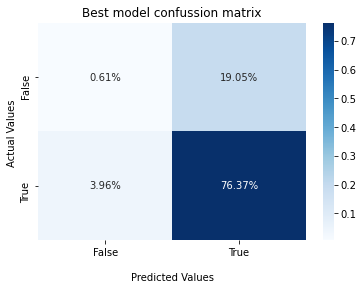

<Figure size 432x288 with 0 Axes>

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv(rf"/home/jovyan/work/data/input/merged_data/train/top_10_train.csv",sep=';')
X, y = df.drop(["good_bad_flag"],axis=1), df['good_bad_flag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, predict_top_10)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Best model confussion matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()
# plt.savefig('my_fig.png', dpi=180)
